**Identify the domain and decide on the problem statement**

**Domain: E-Commerce**

**Problem Statement: Analyzing Trends and Sentiments to Predict Product Popularity**

**Overview:**

In the e-commerce sector, predicting product popularity is essential for managing inventory, refining marketing strategies, and boosting customer satisfaction. By leveraging data such as product titles, descriptions, ratings, review counts, and prices, businesses can gain insights into product performance and market trends.

**Collect or select a relevant real-world dataset. The dataset should be
domain-specific and substantial enough to perform meaningful analysis.**

In [1]:

!pip install autoscraper

In [2]:
import os
import csv
import time
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import concurrent.futures

class AmazonProductScraper:
    def __init__(self):
        self.category_name = None
        self.formatted_category_name = None
        self.max_pages = 100  # Maximum number of pages to scrape

    def fetch_webpage_content(self, url):
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, Gecko) Chrome/94.0.4606.61 Safari/537.36"
        }
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Raise an HTTPError for bad responses
            return response.text
        except requests.exceptions.RequestException as e:
            print(f"Error fetching URL: {e}")
            return None

    def get_category_url(self):
        self.category_name = input("\n>> Enter the product/category to be searched: ")
        self.formatted_category_name = self.category_name.replace(" ", "+")
        category_url = f"https://www.amazon.in/s?k={self.formatted_category_name}&ref=nb_sb_noss"
        print(">> Category URL: ", category_url)
        return category_url

    @staticmethod
    def truncate_title(title, max_words=15):
        words = title.split()[:max_words]
        return ' '.join(words)

    @staticmethod
    def extract_product_information(page_results):
        temp_record = []
        for item in page_results:
            try:
                product_title = item.h2.a.text.strip().replace(',', '')
                title = product_title.split()[:5]
                name = ' '.join(title)
            except AttributeError:
                name = "N/A"

            try:
                product_price = item.find('span', 'a-offscreen').text[1:]  # Remove currency symbol
            except AttributeError:
                product_price = "N/A"

            try:
                product_review = item.i.text.strip()
            except AttributeError:
                product_review = "N/A"

            try:
                review_number = item.find('span', {'class': 'a-size-base'}).text
            except AttributeError:
                review_number = "N/A"

            description = item.h2.a.text.strip()

            product_information = (name, product_price, product_review, review_number, description)
            temp_record.append(product_information)

        return temp_record

    def process_page(self, page_number, category_url):
        print(f">> Page {page_number} - Extracting webpage information")
        next_page_url = category_url + f"&page={page_number}"
        page_content = self.fetch_webpage_content(next_page_url)

        if page_content:
            soup = BeautifulSoup(page_content, 'html.parser')
            page_results = soup.find_all('div', {'data-component-type': 's-search-result'})
            return self.extract_product_information(page_results)
        else:
            return []

    def navigate_to_other_pages(self, category_url):
        records = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future_to_page = {executor.submit(self.process_page, page_number, category_url): page_number for page_number in range(2, self.max_pages + 1)}
            for future in concurrent.futures.as_completed(future_to_page):
                page_number = future_to_page[future]
                try:
                    temp_record = future.result()
                    records += temp_record
                    # Rate limiting to avoid getting blocked
                    time.sleep(1)
                except Exception as e:
                    print(f"Exception occurred for page {page_number}: {e}")

        print("\n>> Creating an excel sheet and entering the details...")
        return records

    def product_information_spreadsheet(self, records):
        file_name = "data.csv"  # Fixed file name

        with open(file_name, "w", newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['Title', 'Price', 'Rating', 'Review Count', 'Description'])
            writer.writerows(records)

        print(f">> Information about the product '{self.category_name}' is stored in {file_name}\n")

        try:
            os.startfile(file_name)  # Open the created file
        except Exception as e:
            print(f"Could not open file: {e}")

if __name__ == "__main__":
    my_amazon_bot = AmazonProductScraper()

    category_details = my_amazon_bot.get_category_url()

    navigation = my_amazon_bot.navigate_to_other_pages(category_details)

    my_amazon_bot.product_information_spreadsheet(navigation)



>> Enter the product/category to be searched: laptops
>> Category URL:  https://www.amazon.in/s?k=laptops&ref=nb_sb_noss
>> Page 2 - Extracting webpage information
>> Page 3 - Extracting webpage information
>> Page 4 - Extracting webpage information
>> Page 5 - Extracting webpage information
>> Page 6 - Extracting webpage information>> Page 7 - Extracting webpage information

>> Page 8 - Extracting webpage information
>> Page 9 - Extracting webpage information
>> Page 10 - Extracting webpage information
>> Page 11 - Extracting webpage information
>> Page 12 - Extracting webpage information>> Page 13 - Extracting webpage information

>> Page 14 - Extracting webpage information
>> Page 15 - Extracting webpage information
>> Page 16 - Extracting webpage information
>> Page 17 - Extracting webpage information
>> Page 18 - Extracting webpage information
>> Page 19 - Extracting webpage information
>> Page 20 - Extracting webpage information
>> Page 21 - Extracting webpage information
>> Pag

In [23]:
import pandas as pd

df = pd.read_csv("/content/data.csv")
print(df.shape)
print(df.columns)

(338, 5)
Index(['Title', 'Price', 'Rating', 'Review Count', 'Description'], dtype='object')


**Clean and preprocess the data to handle missing values and outliers and perform
necessary transformations.**

In [24]:
df.head()

,Title,Price,Rating,Review Count,Description
0,Dell 15 Thin & Light,"46,990",3.6 out of 5 stars,748,"Dell 15 Thin & Light Laptop, 12th Gen Intel Co..."
1,HP Laptop 15 12th Gen,"47,999.90",4.0 out of 5 stars,493,"HP Laptop 15, 12th Gen i5-1235U, 15.6-inch (39..."
2,Dell 14 Thin & Light,"36,890",3.6 out of 5 stars,748,"Dell 14 Thin & Light Laptop, 12th Gen Intel Co..."
3,Acer Aspire Lite AMD Ryzen,"34,990",3.9 out of 5 stars,515,Acer Aspire Lite AMD Ryzen 5 5500U Premium Thi...
4,Acer Aspire 3 Laptop Intel,"21,990",NaN,M.R.P:,Acer Aspire 3 Laptop Intel Core Celeron N4500 ...


In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         338 non-null    object
 1   Price         335 non-null    object
 2   Rating        319 non-null    object
 3   Review Count  338 non-null    object
 4   Description   338 non-null    object
dtypes: object(5)
memory usage: 13.3+ KB
None


In [26]:
#statical info print
df.describe()

,Title,Price,Rating,Review Count,Description
count,338,335,319,338,338
unique,147,164,20,124,224
top,Acer [Smartchoice] Aspire Lite AMD,"63,990",4.0 out of 5 stars,M.R.P:,Acer [Smartchoice] Aspire Lite AMD Ryzen 7 570...
freq,9,12,66,16,9


In [27]:
print(df.isnull().sum())

Title            0
Price            3
Rating          19
Review Count     0
Description      0
dtype: int64


In [28]:
# Convert 'Price' and 'Review Count' to numeric
df['Price'] = pd.to_numeric(df['Price'].str.replace('$', '').str.replace(',', ''), errors='coerce')



In [29]:
def clean_review_count(value):
    # Removing non-numeric characters
    cleaned_value = ''.join(filter(str.isdigit, value))
    # Converting to integer
    return int(cleaned_value) if cleaned_value else 0

# Applying the cleaning function to the 'Review Count' column
df['Review Count'] = df['Review Count'].apply(clean_review_count)



In [30]:
import numpy as np
def extract_numeric_rating(rating_text):
    try:

        return float(rating_text.split(' out')[0])
    except (AttributeError, ValueError):
        return np.nan

df['Numeric Rating'] = df['Rating'].apply(extract_numeric_rating)

df['Numeric Rating'].fillna(df['Numeric Rating'].median(), inplace=True)
df['Price'].fillna(df['Price'].median(), inplace=True)
df['Review Count'].fillna(df['Review Count'].median(), inplace=True)

# Drop the original 'Rating' column
df.drop(columns=['Rating'], inplace=True)

In [31]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           338 non-null    object 
 1   Price           338 non-null    float64
 2   Review Count    338 non-null    int64  
 3   Description     338 non-null    object 
 4   Numeric Rating  338 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 13.3+ KB
None
Title             0
Price             0
Review Count      0
Description       0
Numeric Rating    0
dtype: int64


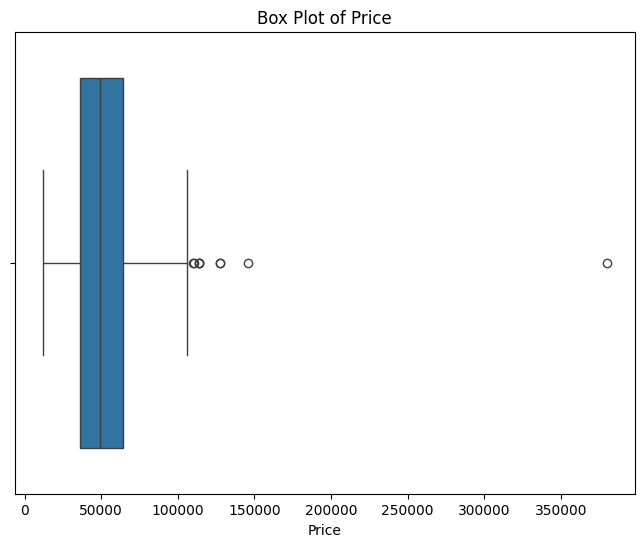

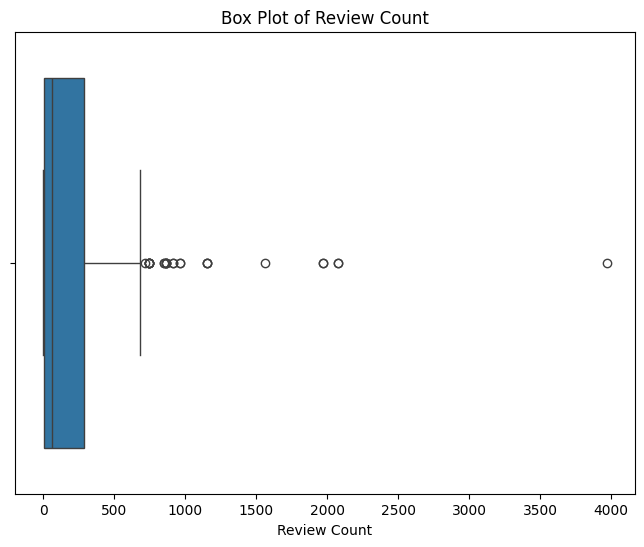

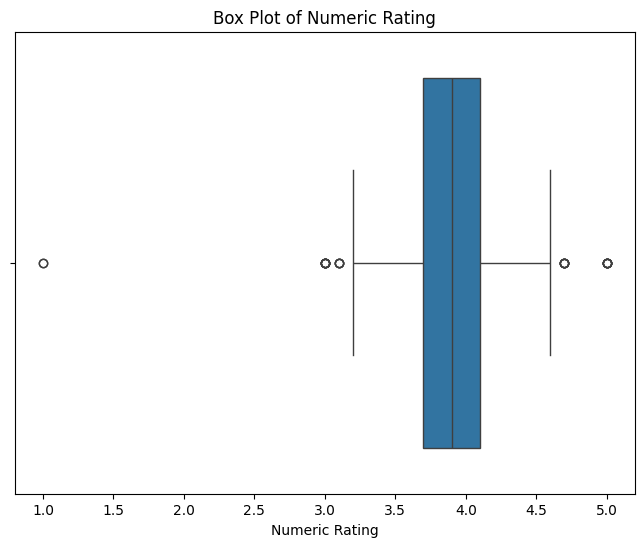

In [33]:
#checking for outliers
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplot(df, column_name):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column_name])
    plt.title(f'Box Plot of {column_name}')
    plt.show()

# Example usage
plot_boxplot(df, 'Price')
plot_boxplot(df, 'Review Count')
plot_boxplot(df, 'Numeric Rating')

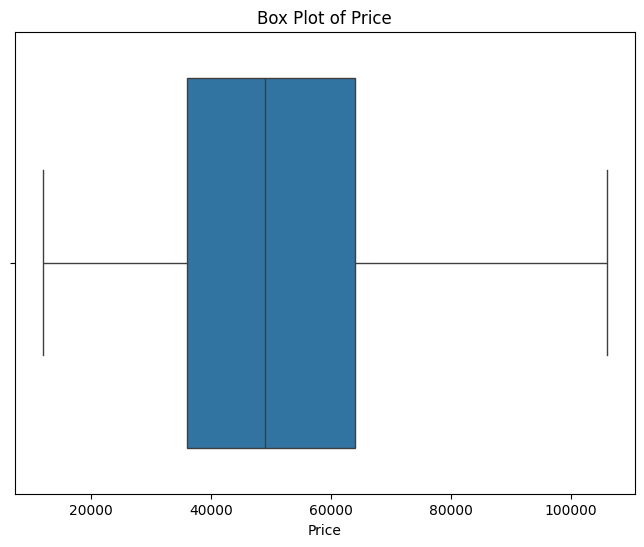

In [34]:
#Handling Outliers
def handle_outliers(df, column_name):

    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df['Price'] = df['Price'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    return df

df = handle_outliers(df, 'Price')

plot_boxplot(df, 'Price')

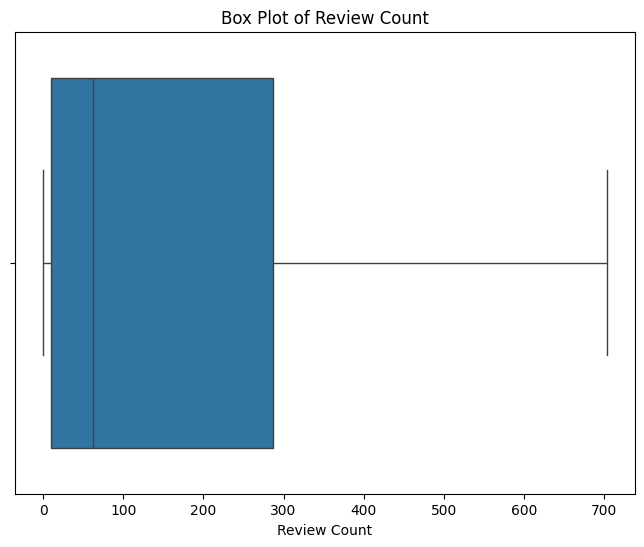

In [35]:
def handle_outliers(df, column_name):

    Q1 = df['Review Count'].quantile(0.25)
    Q3 = df['Review Count'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df['Review Count'] = df['Review Count'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    return df

df = handle_outliers(df, 'Review Count')

plot_boxplot(df, 'Review Count')

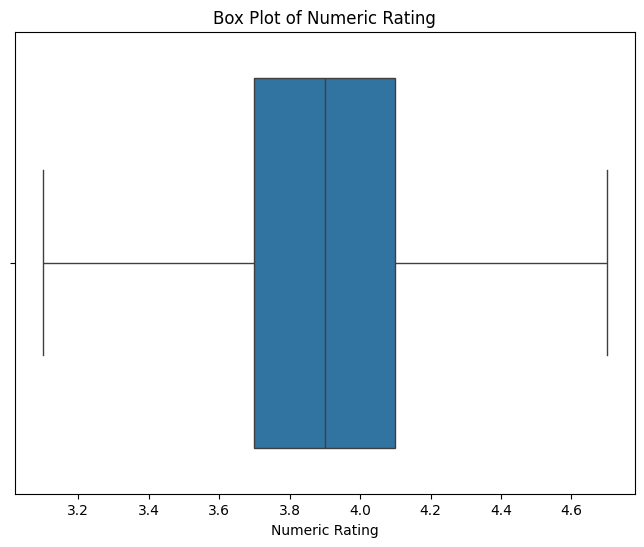

In [36]:
def handle_outliers(df, column_name):

    Q1 = df[ 'Numeric Rating'].quantile(0.25)
    Q3 = df[ 'Numeric Rating'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[ 'Numeric Rating'] = df[ 'Numeric Rating'].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    return df

df = handle_outliers(df,  'Numeric Rating')

plot_boxplot(df,  'Numeric Rating')

In [37]:
# Scaling and Normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_features(df, column_names, scaler_type='standard'):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()

    df[column_names] = scaler.fit_transform(df[column_names])
    return df
df = scale_features(df, ['Price', 'Review Count','Numeric Rating'], scaler_type='standard')



In [38]:
df.head()

,Title,Price,Review Count,Description,Numeric Rating
0,Dell 15 Thin & Light,-0.200200,2.363669,"Dell 15 Thin & Light Laptop, 12th Gen Intel Co...",-0.891956
1,HP Laptop 15 12th Gen,-0.154778,1.425222,"HP Laptop 15, 12th Gen i5-1235U, 15.6-inch (39...",0.265361
2,Dell 14 Thin & Light,-0.654468,2.363669,"Dell 14 Thin & Light Laptop, 12th Gen Intel Co...",-0.891956
3,Acer Aspire Lite AMD Ryzen,-0.739924,1.523477,Acer Aspire Lite AMD Ryzen 5 5500U Premium Thi...,-0.023968
4,Acer Aspire 3 Laptop Intel,-1.324624,-0.776582,Acer Aspire 3 Laptop Intel Core Celeron N4500 ...,-0.023968


In [39]:
# Transformation of catogorical to numeric
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Title'] = encoder.fit_transform(df['Title'])
df['Description'] = encoder.fit_transform(df['Description'])

In [40]:
df.head()

,Title,Price,Review Count,Description,Numeric Rating
0,56,-0.200200,2.363669,82,-0.891956
1,74,-0.154778,1.425222,108,0.265361
2,54,-0.654468,2.363669,78,-0.891956
3,40,-0.739924,1.523477,60,-0.023968
4,36,-1.324624,-0.776582,49,-0.023968


**Implement at least five machine learning / deep learning algorithms or
Integrated/Hybrid/Noval on the collected or selected dataset.**

**Analyze the results of the algorithms using at least five suitable metrics (e.g.,
accuracy, precision, recall, F1 score, ROC-AUC, etc.).**

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
X = df[['Title', 'Price', 'Review Count', 'Description']]
y = df['Numeric Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Linear Regression**

Linear Regression Metrics:
MSE: 0.9335483963455001
RMSE: 0.9662030823514797
MAE: 0.7096540049999528
R2 Score: 0.005807671250863122
Explained Variance: 0.04484997373578026



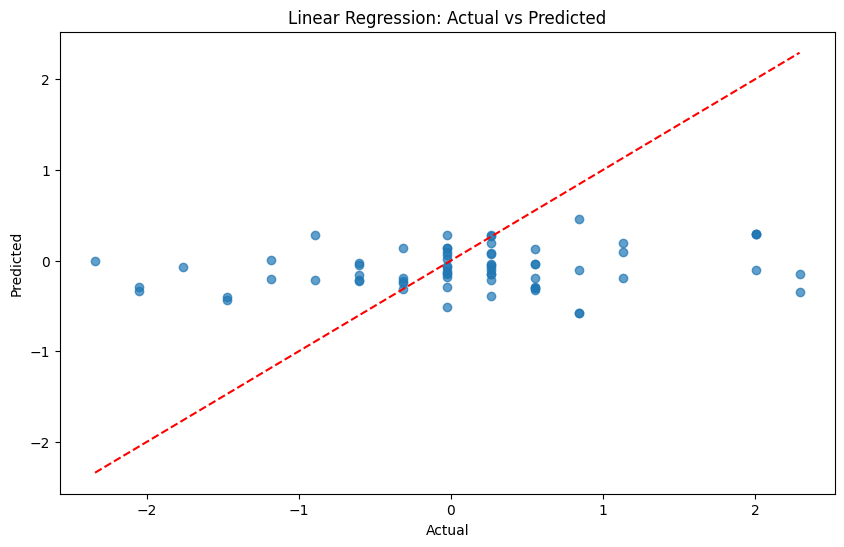

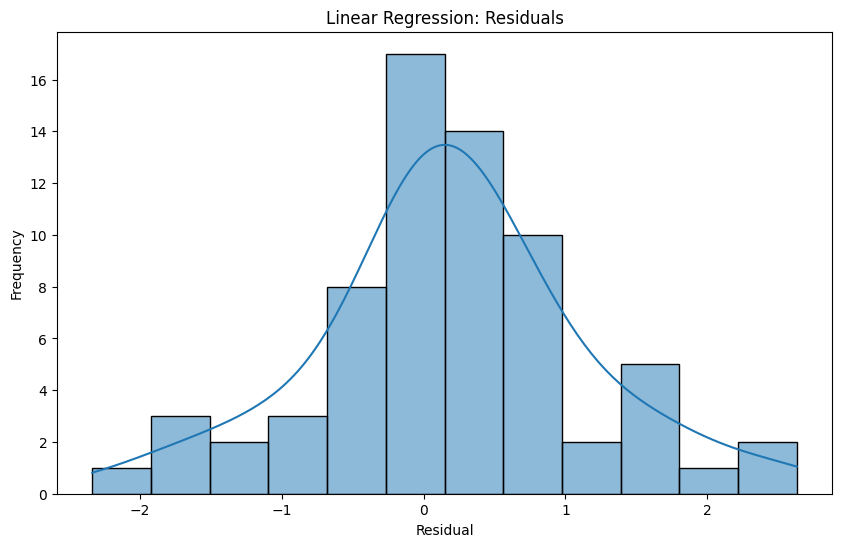

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print(f"Linear Regression Metrics:\nMSE: {mse}\nRMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}\nExplained Variance: {evs}\n")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Linear Regression: Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


**Interpretation:**

Linear Regression model performance metrics indicate it is not effectively predicting Numeric Rating based on the provided features. The model predictions are not significantly better than using a simple average, suggesting that the feature set may need enhancement

**K-Means Custring**

In [48]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
features = df[['Price', 'Review Count']]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

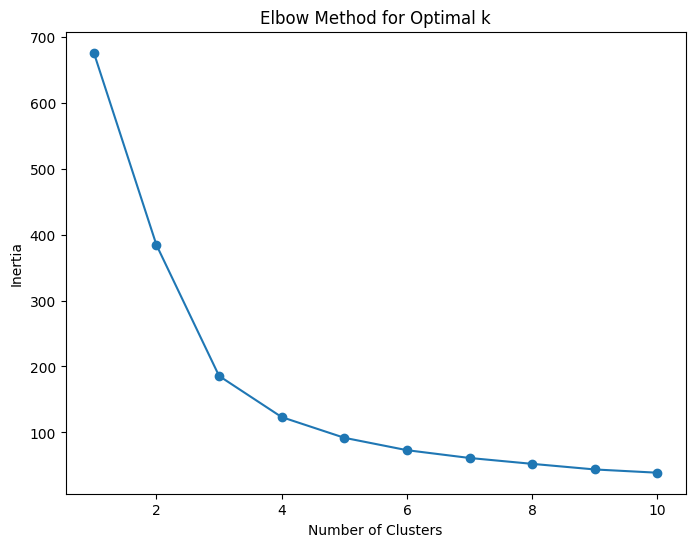

In [76]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Number of clusters: 2, Silhouette Score: 0.4775327216365936
Number of clusters: 3, Silhouette Score: 0.5019640920473412
Number of clusters: 4, Silhouette Score: 0.4916451980597101
Number of clusters: 5, Silhouette Score: 0.49061911404204117
Number of clusters: 6, Silhouette Score: 0.4642924708642203
Number of clusters: 7, Silhouette Score: 0.46206438039194625
Number of clusters: 8, Silhouette Score: 0.48208252875277324
Number of clusters: 9, Silhouette Score: 0.46801057747499436


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 10, Silhouette Score: 0.4767738042058258
Silhouette Scores for different k values:
[0.4775327216365936, 0.5019640920473412, 0.4916451980597101, 0.49061911404204117, 0.4642924708642203, 0.46206438039194625, 0.48208252875277324, 0.46801057747499436, 0.4767738042058258]


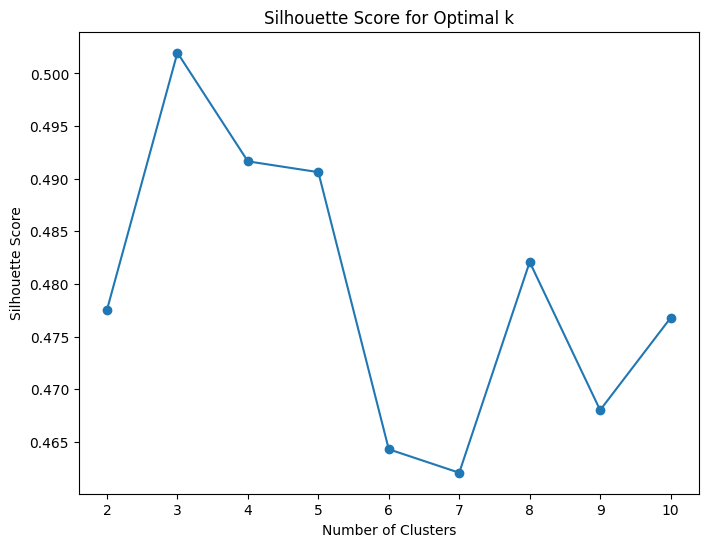

In [77]:
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(features)
    score = silhouette_score(features, clusters)
    silhouette_scores.append(score)
    print(f'Number of clusters: {k}, Silhouette Score: {score}')
print("Silhouette Scores for different k values:")
print(silhouette_scores)


# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [78]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(features)

df['Cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


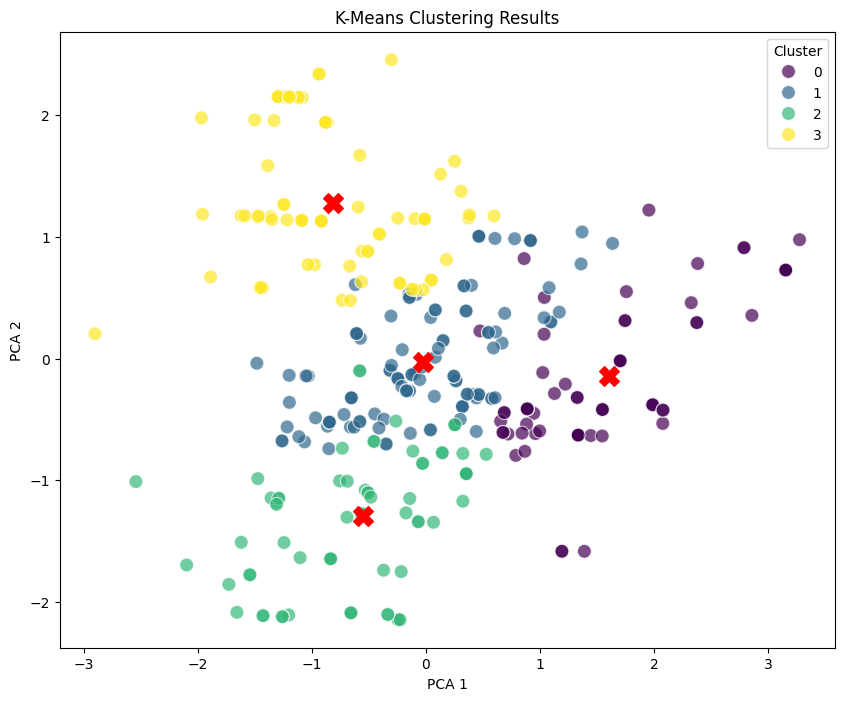

In [74]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)
df['PCA1'] = principal_components[:, 0]
df['PCA2'] = principal_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clustering Results')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X', label='Centroids')

plt.show()

**Interpretation:**

The clear separation of clusters in the PCA plot shows that Price and Review Count are effective in differentiating products. Each cluster represents distinct product segments with similar attributes. This separation implies that the features capture significant variations between products, offering valuable insights for targeted marketing and product strategy.

**Random Forest Regression**

Random Forest Regressor Metrics:
MSE: 0.6951
RMSE: 0.8337
MAE: 0.5085
R2 Score: 0.2597
Explained Variance: 0.3055


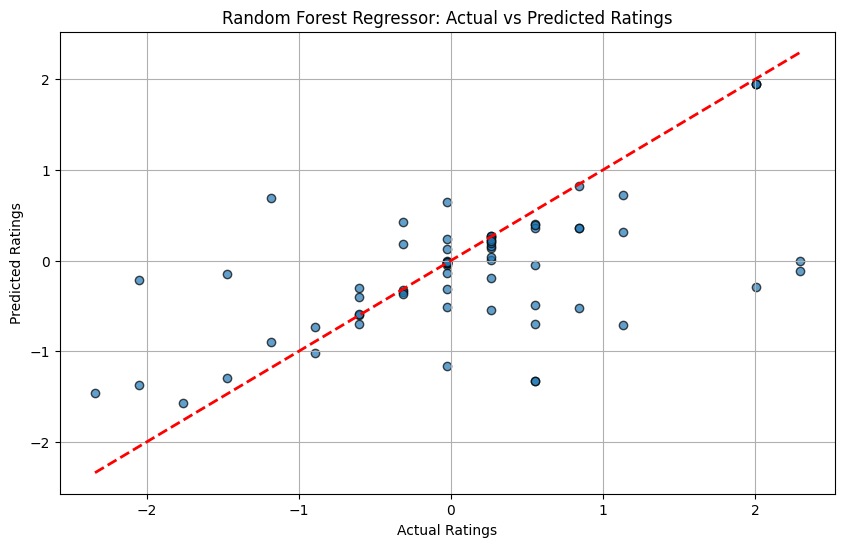

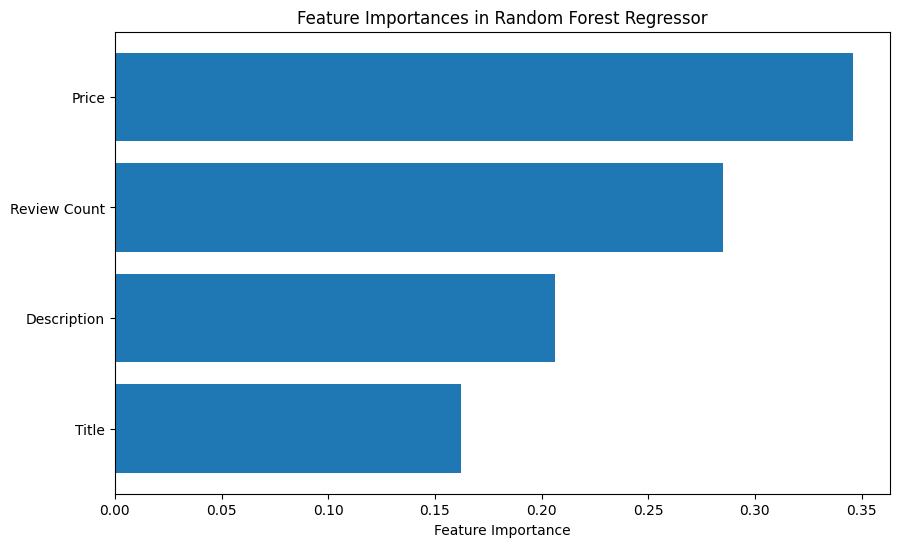

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split


X = df[['Title', 'Price', 'Review Count', 'Description']]
y = df['Numeric Rating']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Print metrics
print("Random Forest Regressor Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Explained Variance: {explained_variance:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Random Forest Regressor: Actual vs Predicted Ratings')
plt.grid(True)
plt.show()

importances = rf_model.feature_importances_
features = X.columns
sorted_indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Random Forest Regressor')
plt.show()


**Interpretation:**

The Random Forest Regressor model shows moderate performance in predicting Numeric Ratings with an R² score of 0.2597, indicating it explains about 26% of the variance. The Mean Squared Error and Root Mean Squared Error suggest a moderate level of prediction error. The Mean Absolute Error indicates that predictions are off by about 0.51 units on average. The model captures roughly 30.55% of the variance in the target variable. Overall, while the model provides some useful predictions.

**Support Vector Regressor**

In [86]:
from sklearn.svm import SVR

# Initialize and train the model
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svr = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
explained_variance_svr = explained_variance_score(y_test, y_pred_svr)

print("Support Vector Regressor Metrics:")
print(f"MSE: {mse_svr}")
print(f"RMSE: {rmse_svr}")
print(f"MAE: {mae_svr}")
print(f"R2 Score: {r2_svr}")
print(f"Explained Variance: {explained_variance_svr}")


Support Vector Regressor Metrics:
MSE: 0.9603100673205887
RMSE: 0.9799541149056872
MAE: 0.7074300221052001
R2 Score: -0.022692455889941954
Explained Variance: -0.020586893285491348


**Interpretation:**

The Support Vector Regressor exhibits poor performance with high MSE, RMSE, and MAE, indicating significant prediction errors. The negative R² score and explained variance suggest that the model is less effective than a simple mean-based approach, failing to capture the variability in the target variable. This suggests that the SVR model is not suitable for this data

**Gradient Boosting Regressor**

In [87]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Initialize and train the model
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gbm = gbm_model.predict(X_test)
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
rmse_gbm = mean_squared_error(y_test, y_pred_gbm, squared=False)
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)
explained_variance_gbm = explained_variance_score(y_test, y_pred_gbm)

print("Gradient Boosting Regressor Metrics:")
print(f"MSE: {mse_gbm}")
print(f"RMSE: {rmse_gbm}")
print(f"MAE: {mae_gbm}")
print(f"R2 Score: {r2_gbm}")
print(f"Explained Variance: {explained_variance_gbm}")


Gradient Boosting Regressor Metrics:
MSE: 0.7271891048480805
RMSE: 0.8527538360207362
MAE: 0.5768098760551345
R2 Score: 0.22557220126984334
Explained Variance: 0.2722752547730174


**Interpretation:**

The Gradient Boosting Regressor shows moderate performance with an R² score of 0.2256, indicating it explains about 22% of the variance in the ratings. The MSE, RMSE, and MAE suggest that there are moderate levels of prediction error. Although the model captures some of the variance in the target variable, there is room for improvement in terms of accuracy and explaining the variability in the data.

**Multi-Layer Perceptron**

In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


X = df[['Price', 'Review Count']]
y = df['Numeric Rating']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Building the Neural Network Model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, verbose=1)

y_pred = model.predict(X_test)




Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0426 - val_loss: 1.2957
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8583 - val_loss: 1.2620
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0196 - val_loss: 1.2619
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9499 - val_loss: 1.2021
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0534 - val_loss: 1.2146
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0272 - val_loss: 1.2016
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0049 - val_loss: 1.2207
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8176 - val_loss: 1.1786
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8314 - val_loss: 1.1840
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9517 - val_loss: 1.1812
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8441 - val_loss: 1.2005
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9385 - val_loss: 1.2106


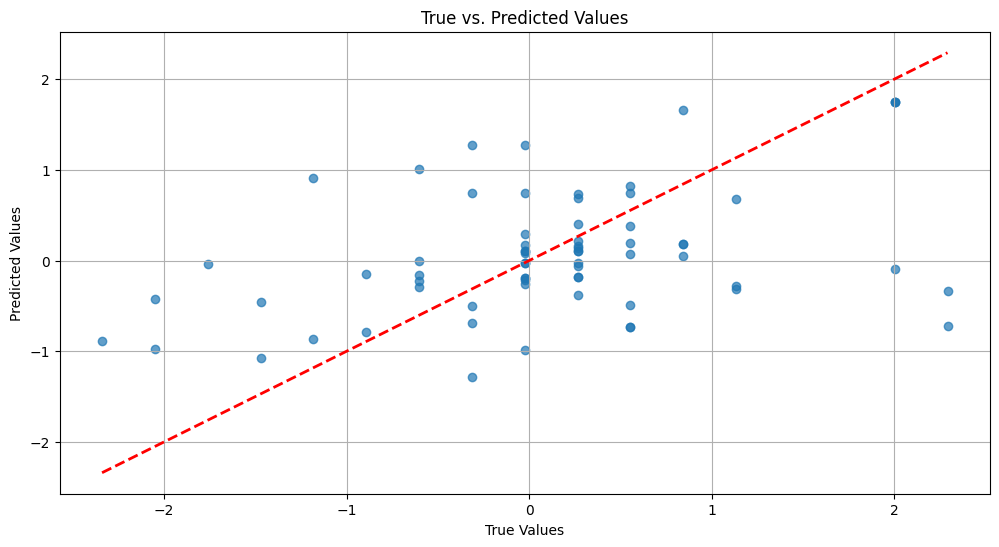

In [93]:
# Scatter plot of true vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


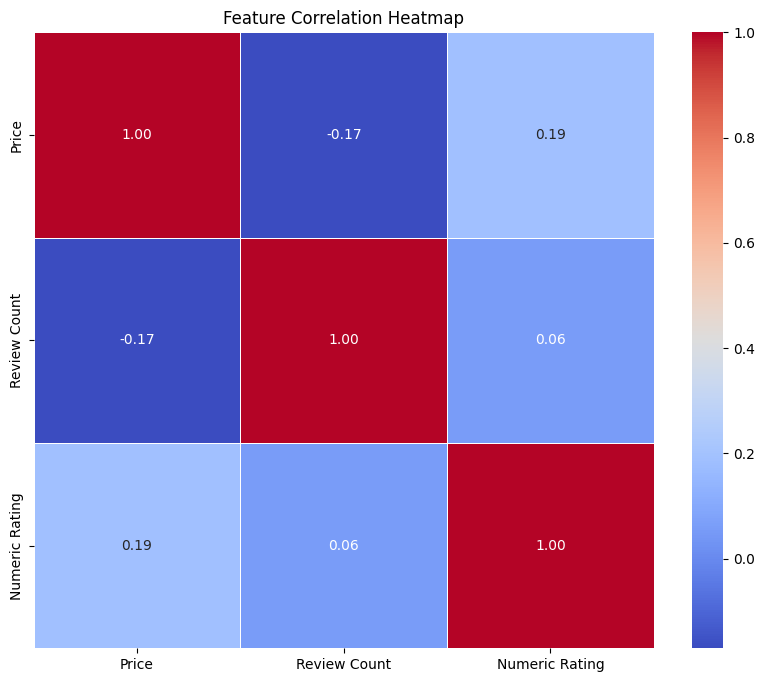

In [99]:
import seaborn as sns

#correlation matrix
corr = df[['Price', 'Review Count', 'Numeric Rating']].corr()

#heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()


In [98]:
# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')

MSE: 0.8011
RMSE: 0.8951
MAE: 0.6451
R2 Score: 0.1468


**Interpretation:**

The MLP model shows improved accuracy with MSE of 0.8011, RMSE of 0.8951, and MAE of 0.6451, reflecting reduced prediction errors. Despite these improvements, the R² score of 0.146 indicates that the model explains only 14.6% of the variance in the target variable, suggesting limited explanatory power.

**Compare the performance of the implemented algorithms based on the chosen
metrics.**

**Random Forest Regressor**

Metrics: MSE: 0.6951, RMSE: 0.8337, MAE: 0.5085, R²: 0.2597, Explained Variance: 0.3055

Insight: The Random Forest Regressor delivers strong performance with lower error metrics and a relatively higher R² score. It explains a moderate amount of variance in the target variable, making it the most effective model among those tested for predicting product popularity.

**Linear Regression**

Metrics: MSE: 0.9335, RMSE: 0.9662, MAE: 0.7097, R²: 0.0058, Explained Variance: 0.0448

Insight: Linear Regression performs poorly with high error rates and an extremely low R² score. It explains very little of the variance in the target variable, indicating that it is not suitable for this dataset and problem.

**Gradient Boosting Regressor**

Metrics: MSE = 0.7272, RMSE = 0.8528, MAE = 0.5768, R² = 0.2256

Insight: The Gradient Boosting Regressor offers moderate performance with lower error rates compared to Decision Trees but less impressive than Random Forests. It has a slightly lower R² score, reflecting a reasonable, though not outstanding, variance explanation.

**Support Vector Regressor (SVR)**

Metrics: MSE = 0.9603, RMSE = 0.9800, MAE = 0.7074, R² = -0.0227

Insight: SVR has the highest MSE and RMSE and a negative R² score, suggesting poor performance relative to other models. It may struggle with the data characteristics or require better parameter tuning.

**Multi-Layer Perceptron (MLP)**

Metrics: MSE = 0.8011, RMSE = 0.8951, MAE = 0.6451, R² = 0.1460

Insight: MLP shows improvement from previous results but still has moderate error rates and a low R² score. It indicates that while deep learning approaches are beneficial, further tuning and optimization are needed.

**Discuss the results, insights, and conclusions drawn from the analysis. Highlight any
integrated, hybrid, or novel approaches used.**


**Overall Insights and Conclusions**

- **Best Model:** Random Forest Regressor is the most effective model for predicting product popularity, providing the lowest error metrics and a good explanation of variance.

- **Intermediate Models:** Gradient Boosting Regressor and Multi-Layer Perceptron offer moderate performance but are less effective compared to Random Forest. They might be improved with further tuning.

- **Poor Performers:** Linear Regression and Support Vector Regressor show the least performance, with high error rates and poor variance explanation. These models might not be suitable for this dataset and problem, or they may need significant adjustment and tuning.
